# Analysis of borrowing -- entropy method
## Based on word tables and using recurrent neural networks  

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Do this once in the kernel.
import sys
sys.path.append('/src/pybor')

# Set to automatically reload.
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [178]:
import py_compile
py_compile.compile('src/pybor/config.py')
py_compile.compile('src/pybor/data.py')
py_compile.compile('src/pybor/entropies.py')
py_compile.compile('src/pybor/evaluate.py')
py_compile.compile('src/pybor/markov.py')
py_compile.compile('src/pybor/neural.py')
py_compile.compile('src/pybor/plot.py')
py_compile.compile('src/pybor/util.py')

'src/pybor/__pycache__/config.cpython-37.pyc'

'src/pybor/__pycache__/data.cpython-37.pyc'

'src/pybor/__pycache__/entropies.cpython-37.pyc'

'src/pybor/__pycache__/evaluate.cpython-37.pyc'

'src/pybor/__pycache__/markov.cpython-37.pyc'

'src/pybor/__pycache__/neural.cpython-37.pyc'

'src/pybor/__pycache__/plot.cpython-37.pyc'

'src/pybor/__pycache__/util.cpython-37.pyc'

In [179]:
#import tensorflow.keras as tfk
#import tensorflow as tf
import pybor.config as config
from pybor.data import LexibankDataset
import pybor.entropies as entropies
import pybor.evaluate as evaluate
import pybor.markov as markov
import pybor.neural as neubor
import pybor.plot as plot
import pybor.util as util

## Review neural network training plots

# Show model

In [33]:
neural.native_model.model.summary()

Model: "German-native-devel-recurrent-emblen32-rnnlen24-celtypLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Segment_embedding (Embedding)   (None, None, 32)     3648        input_3[0][0]                    
__________________________________________________________________________________________________
LSTM_recurrent (LSTM)           (None, None, 24)     5472        Segment_embedding[0][0]          
__________________________________________________________________________________________________
Dropout_rnn_output (Dropout)    (None, None, 24)     0           LSTM_recurrent[0][0]             
_________________________________________

# Generalize to allow any language dataset access  

In [62]:
from matplotlib import pyplot as plt

def plot_model_measures(
        measures=None,
        title=None,
        output_path=None,
        ):
    ## From Keras example
    print('measures', measures.keys())
    # Plot training & validation accuracy values
    plt.plot(measures['loss'][1:])
    plt.plot(measures['val_loss'][1:])
    if title:
        plt.title(title)
    plt.ylabel('Model Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation crossentropy values
    # Seemingly redundant with perplexity, so not needed.
    plt.plot(measures['sparse_categorical_accuracy'][1:])
    plt.plot(measures['val_sparse_categorical_accuracy'][1:])
    if title:
        plt.title(title)
    plt.ylabel('Model Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    if output_path is not None:
        plt.savefig(output_path, dpi=600)
        plt.close()

        
#plot_model_measures(neural.native_history, neural.native_model.model.name)
#plot_model_measures(neural.loan_history, neural.loan_model.model.name)

In [212]:
from matplotlib import pyplot as plt
import statistics
import math
import numpy as np

def plot_entropies(
    entropies1=None,
    entropies2=None,
    output_path=None,
    title='',
    label1='',
    label2='',
    graph_limit=None):
    
    # entropies1.
    # entropies2.
    # language - name of language for identification in figures and reports.
    # title - title for graph.
    # graphlimit - upper graph limit for histogram bins.


    cnt1 = f"{len(entropies1):6d}"
    avg1 = f"{statistics.mean(entropies1):6.3f}"
    std1 = f"{statistics.stdev(entropies1):6.3f}"
    cnt2 = f"{len(entropies2):6d}"
    avg2 = f"{statistics.mean(entropies2):6.3f}"
    std2 = f"{statistics.stdev(entropies2):6.3f}"

    # Drop most extreme values to determine graph limit.
    entropies = sorted(entropies1 + entropies2)
    upper_limit = graph_limit if graph_limit is not None else math.ceil(entropies[-4])
    lower_limit = math.floor(entropies[0])
    
    # Set frame horizontal for this measure.
    bins = np.linspace(lower_limit, upper_limit, 60)
    plt.figure(figsize=(8, 5))
    plt.hist(
        entropies1,
        bins,
        alpha=0.65,
        label=label1
        + r"$(n="
        + cnt1
        + ", \mu="
        + avg1
        + ", \sigma="
        + std1
        + ")$",
        color="blue",
    )
    plt.hist(
        entropies2,
        bins,
        alpha=0.65,
        label=label2
        + r"$(n="
        + cnt2
        + ", \mu="
        + avg2
        + ", \sigma="
        + std2
        + ")$",
        color="red",
    )
    plt.grid(axis="y", alpha=0.8)
    plt.legend(loc="upper right")

    plt.xlabel("Entropies")
    plt.ylabel("Frequency")
    plt.title(title)

    plt.show()
    # Build file output and write
    if output_path:
        plt.savefig(output_path, dpi=600)

    plt.close()



In [213]:
def plot_entropy_distributions(neural=None):
    # Will get corresponding data and models from neubor.
    
    # Plot fit data from native and loan - native basis.
    native_fit_tokens_ids = neural.native_data.get_data_tokens_ids(neural.native_data.fit)
    loan_fit_tokens_ids = neural.loan_data.get_data_tokens_ids(neural.loan_data.fit)
    native_fit_entropies_native = neural.native_model.calculate_entropies(native_fit_tokens_ids)
    loan_fit_entropies_native = neural.native_model.calculate_entropies(loan_fit_tokens_ids)
    plot_entropies(native_fit_entropies_native, loan_fit_entropies_native, 
                   title="Native versus loan fit entropies - Native basis", 
                   label1='Native fit entropies', label2='Loan fit entropies')
    
    #Plot val and test data from native and loan - native basis.
    native_valtest_data = neural.native_data.val + neural.native_data.testing
    loan_valtest_data = neural.loan_data.val + neural.loan_data.testing
    native_valtest_tokens_ids = neural.native_data.get_data_tokens_ids(native_valtest_data)
    loan_valtest_tokens_ids = neural.loan_data.get_data_tokens_ids(loan_valtest_data)
    native_valtest_entropies_native = neural.native_model.calculate_entropies(native_valtest_tokens_ids)
    loan_valtest_entropies_native = neural.native_model.calculate_entropies(loan_valtest_tokens_ids)
    plot_entropies(native_valtest_entropies_native, loan_valtest_entropies_native, 
                   title="Native versus loan val-test entropies - Native basis", 
                   label1='Native val-test entropies', label2='Loan val-test entropies')

    plot_entropies(native_fit_entropies_native, native_valtest_entropies_native, 
                   title="Native fit versus val-test entropies - Native basis", 
                   label1='Native fit entropies', label2='Native val-test entropies')

    if neural.loan_model is None: return  
    
    # Plot fit data from native and loan - loan basis.
    native_fit_entropies_loan = neural.loan_model.calculate_entropies(native_fit_tokens_ids)
    loan_fit_entropies_loan = neural.loan_model.calculate_entropies(loan_fit_tokens_ids)
    plot_entropies(native_fit_entropies_loan, loan_fit_entropies_loan, 
                   title="Native versus loan fit entropies - Loan basis", 
                   label1='Native fit entropies', label2='Loan fit entropies')

    
    #Plot val and test data from native and loan - loan basis.
    native_valtest_entropies_loan = neural.loan_model.calculate_entropies(native_valtest_tokens_ids)
    loan_valtest_entropies_loan = neural.loan_model.calculate_entropies(loan_valtest_tokens_ids)
    plot_entropies(native_valtest_entropies_loan, loan_valtest_entropies_loan, 
                   title="Native versus loan val-test entropies - Loan basis", 
                   label1='Native val-test entropies', label2='Loan val-test entropies')

    plot_entropies(loan_fit_entropies_loan, loan_valtest_entropies_loan, title="Loan fit versus val-test entropies - Loan basis", 
                   label1='Native fit entropies', label2='Native val-test entropies')

    # Single data source, dual basis
    plot_entropies(native_fit_entropies_native, native_fit_entropies_loan, 
                   title="Native fit entropies - Native versus loan basis", 
                   label1='Native basis', label2='Loan basis')

    plot_entropies(native_valtest_entropies_native, native_valtest_entropies_loan, 
                   title="Native valtest entropies - Native versus loan basis", 
                   label1='Native basis', label2='Loan basis')

    plot_entropies(loan_fit_entropies_native, loan_fit_entropies_loan, 
                   title="Loan fit entropies - Native versus loan basis", 
                   label1='Native basis', label2='Loan basis')

    plot_entropies(loan_valtest_entropies_native, loan_valtest_entropies_loan, 
                   title="Loan valtest entropies - Native versus loan basis", 
                   label1='Native basis', label2='Loan basis')

    

In [207]:
import pickle
from pathlib import Path

import attr

import pybor.config as config
import pybor.util as util

output_path = Path(BaseSettings().output_path).resolve()


def evaluate_prediction(model=None, data=None, title=''):
    print(f"Evaluate {title} dataset.")
    predictions = model.predict_data(data)
    train_metrics = evaluate.evaluate_model(predictions, data)
    evaluate.print_evaluation(train_metrics)
    #evaluate.false_positive(predictions, training1)


def evaluate_borrowing_prediction_train_test(language=None, 
                                             train=None, 
                                             test=None, 
                                             detect_type=None,
                                             model_type=None,
                                             val_split=None,
                                             settings=None):

    print(f'*** Evaluation for {language}, detect type is {detect_type}, neural model type is {model_type}')

    if detect_type == 'native':
        neural = neubor.NeuralNative(training=train,
                              testing=test,
                              language=language,
                              series='devel',
                              model_type=model_type,
                              val_split=val_split,
                              settings=settings)
        
        
    else:
        neural = neubor.NeuralDual(training=train,
                            testing=test,
                            language=language,
                            series='devel',
                            model_type=model_type,
                            val_split=val_split,
                            settings=settings)

    neural.train()

    evaluate_prediction(neural, train, 'Training')
    evaluate_prediction(neural, test, 'Testing')   
    
    plot_model_measures(neural.native_history, 'native model')
    if detect_type == 'dual':    
        plot_model_measures(neural.loan_history, 'loan model')    
    
    plot_entropy_distributions(neural)

    
def perform_prediction_by_language(languages=None, 
                                   form=None, 
                                   detect_type=None, 
                                   model_type=None, 
                                   test_split=None, 
                                   settings=None):

    try:
        with open('wold.bin', 'rb') as f:
            lex = pickle.load(f)
    except:
        lex = LexibankDataset(
                'wold',
                transform={
                    "Loan": lambda x, y, z: 1 if x['Borrowed'].startswith('1') else 0}
                )
        with open('wold.bin', 'wb') as f:
            pickle.dump(lex, f)

    if languages == 'all':
        languages = [language["Name"] for language in lex.languages.values()]
    elif isinstance(languages, str):
        languages = [languages]
    elif not isinstance(languages, list):
        print("Language must be language name, list of languages, or keyword 'all'.")

    print(f'Languages {languages}.')
    for language in languages:
        table = lex.get_table(
                    language=language,
                    form=form,
                    classification='Loan'
                    )

        train, test = util.train_test_split(table, split=test_split)

        val_split = (test_split if test_split is None or test_split >= 1.0
                                else test_split/(1-test_split))
        evaluate_borrowing_prediction_train_test(language=language, 
                                                 train=train, 
                                                 test=test,
                                                 detect_type=detect_type,
                                                 model_type=model_type, 
                                                 val_split=val_split,
                                                 settings=settings)


#perform_prediction_by_language(languages='Hup', form='Tokens', detect_type='dual', model_type='recurrent', test_split=0.20, settings=settings)
       

# Stand alone datset in form of \[ident, [str], status]

*** Evaluation for German, detect type is dual, neural model type is recurrent
pybor.neural — INFO — Train length: 868, fit length: 694, val length: 174, test length: 160.
pybor.neural — INFO — Train length: 145, fit length: 116, val length: 29, test length: 19.
pybor.neural — INFO — training native model
pybor.entropies — INFO — Training recurrent neural model.
pybor.entropies — INFO — Best epoch: 40 of 50. Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.4386, accuracy=0.2077
pybor.entropies — INFO — Validate dataset: loss=1.4450, accuracy=0.2095
pybor.neural — INFO — training loan model
pybor.entropies — INFO — Training recurrent neural model.
pybor.entropies — INFO — Best epoch: 46 of 50. Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=2.0257, accuracy=0.1238
pybor.entropies — INFO — Validate dataset: loss=1.9871, accuracy=0.1111
Evaluate Training dataset.
|   Precision |   Recall |   F-score |   Accuracy |   Majority |
|----------

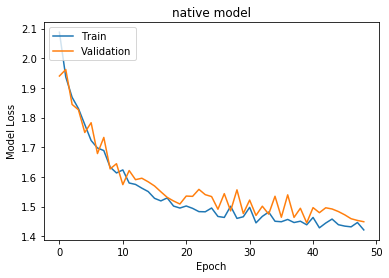

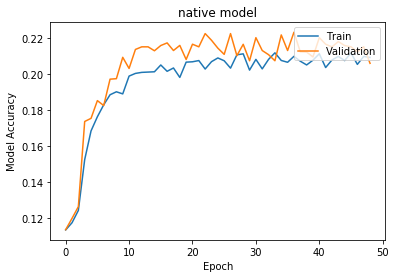

measures dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


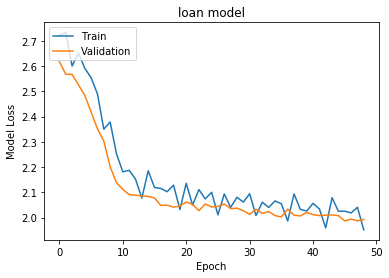

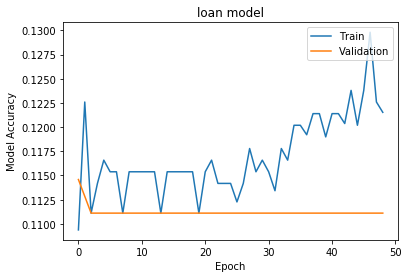

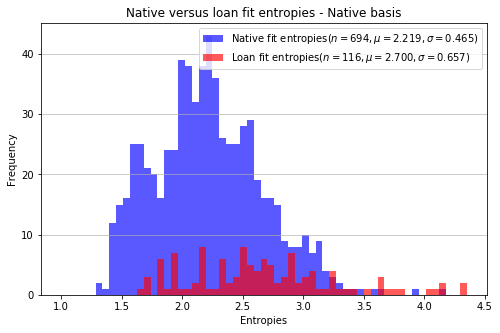

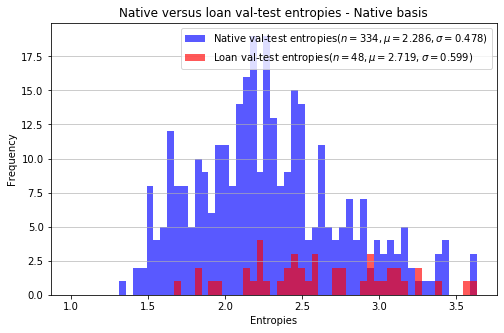

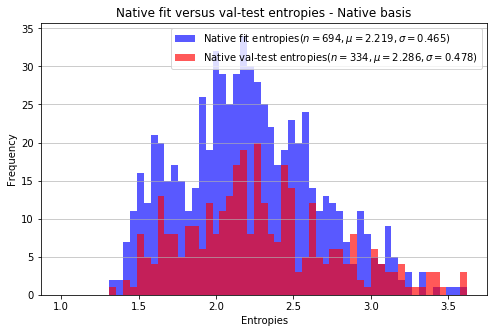

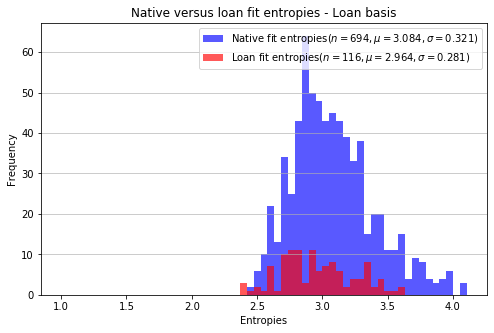

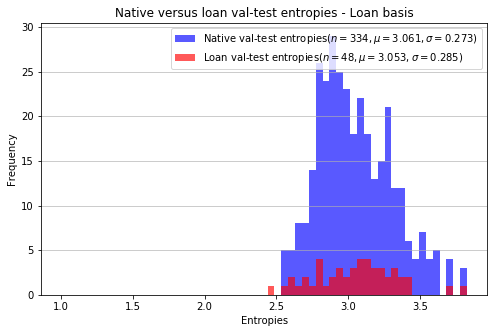

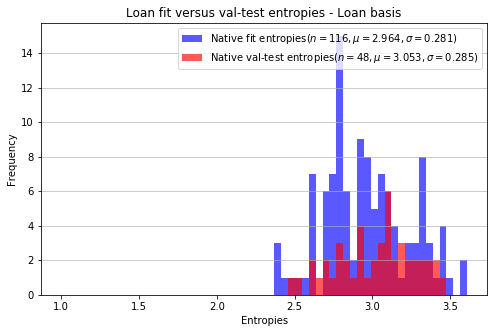

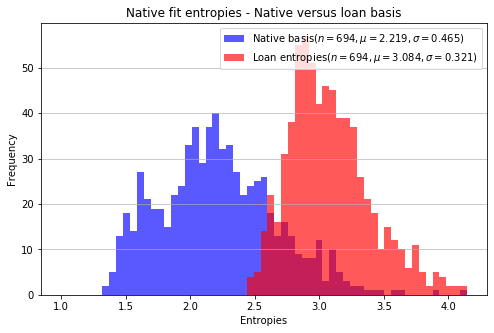

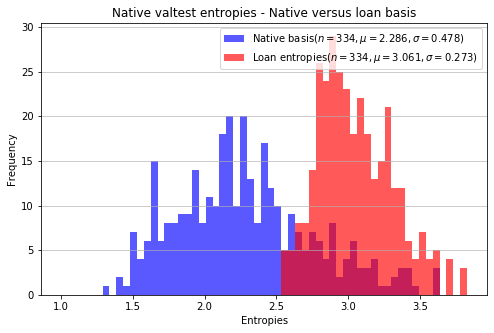

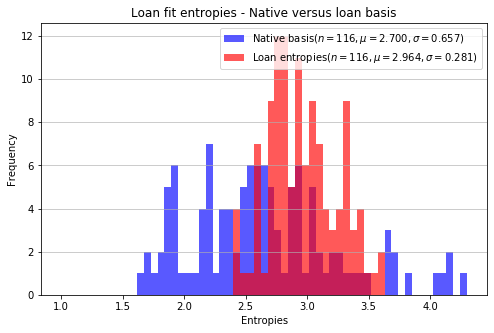

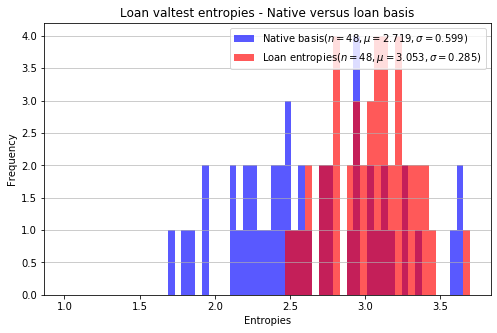

In [210]:
# Testing data from German.
from pybor.dev.data import training1, testing1

evaluate_borrowing_prediction_train_test(language="German", 
                                         train=training1, 
                                         test=testing1, 
                                         detect_type='dual',
                                         model_type="recurrent", 
                                         val_split=0.2)

# Datasets selected from WOLD in format \[ident, [str], status]

Languages ['Hup'].
*** Evaluation for Hup, detect type is dual, neural model type is recurrent
pybor.neural — INFO — Train length: 848, fit length: 636, val length: 212, test length: 212.
pybor.neural — INFO — Train length: 95, fit length: 71, val length: 24, test length: 24.
pybor.neural — INFO — training native model
pybor.entropies — INFO — Training recurrent neural model.
pybor.entropies — INFO — Best epoch: 37 of 50. Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.2814, accuracy=0.1599
pybor.entropies — INFO — Validate dataset: loss=1.2534, accuracy=0.1408
pybor.neural — INFO — training loan model
pybor.entropies — INFO — Training recurrent neural model.
pybor.entropies — INFO — Best epoch: 49 of 50. Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.6910, accuracy=0.1176
pybor.entropies — INFO — Validate dataset: loss=1.8242, accuracy=0.1122
Evaluate Training dataset.
|   Precision |   Recall |   F-score |   Accuracy |   Majority

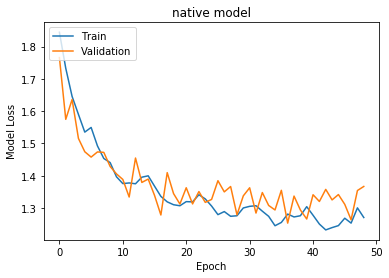

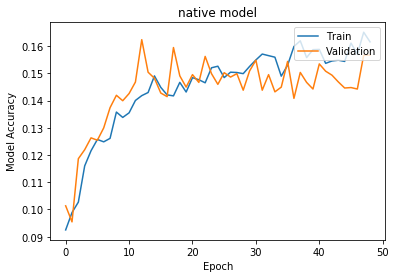

measures dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


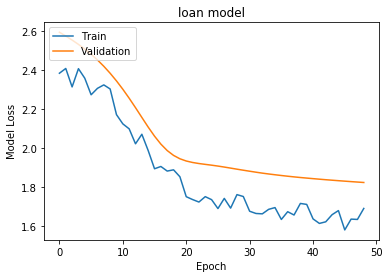

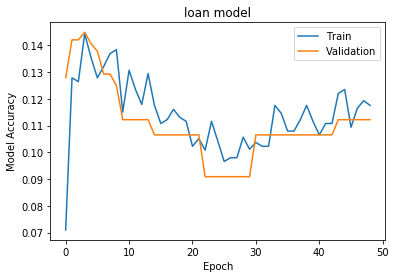

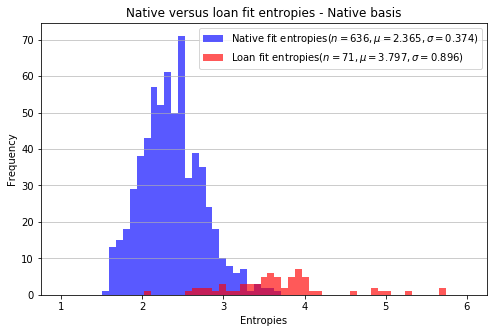

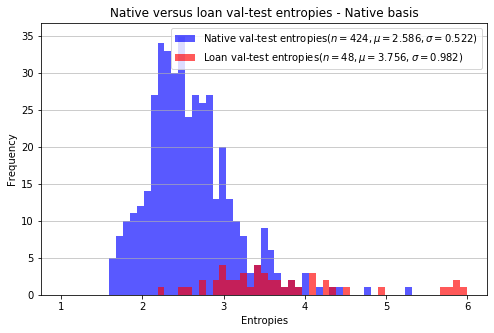

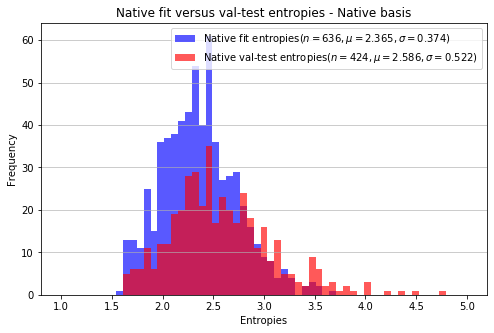

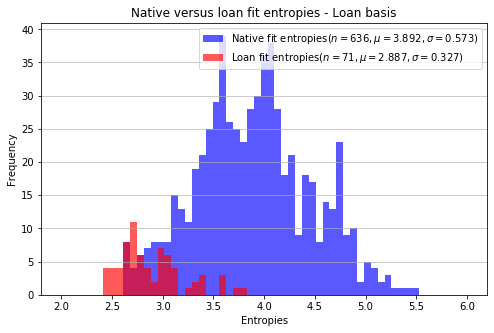

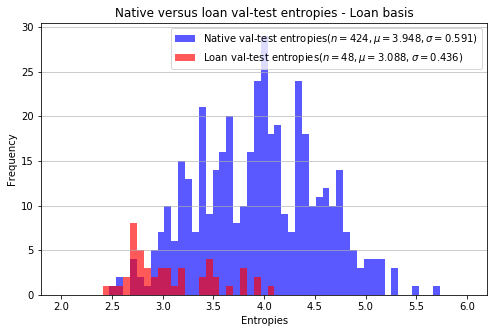

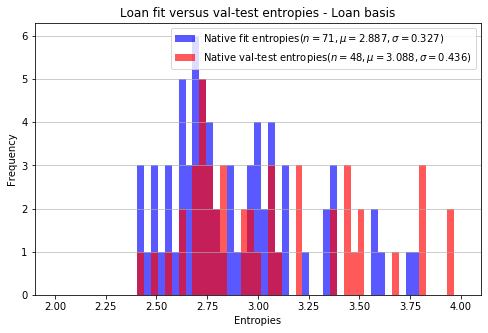

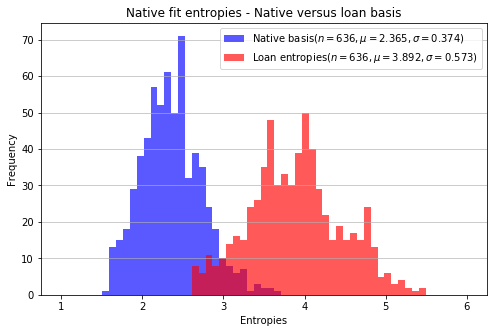

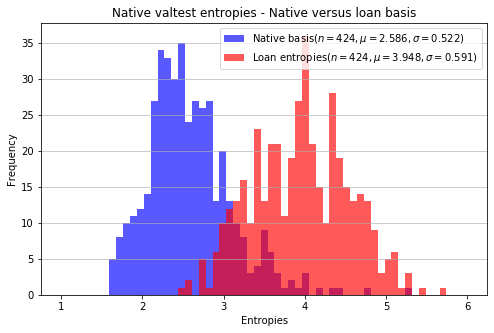

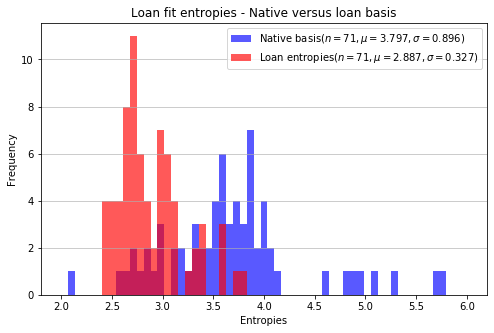

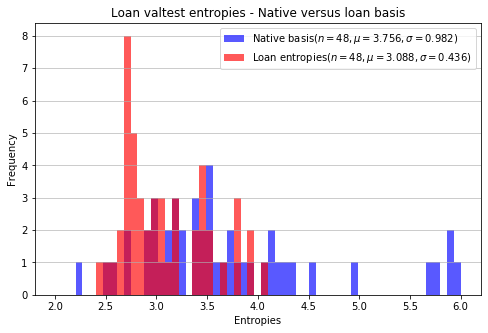

In [214]:
settings = config.RecurrentSettings(rnn_cell_type='GRU', embedding_len=32, 
                                    rnn_output_len=32, recurrent_l2=0.0015,
                                    rnn_levels=1)

perform_prediction_by_language(languages='Hup', 
                               form='Tokens', 
                               detect_type='dual', 
                               model_type='recurrent', 
                               test_split=0.20,
                               settings=settings)

Languages ['Hup'].
*** Evaluation for Hup, detect type is dual, neural model type is recurrent
pybor.neural — INFO — Train length: 845, fit length: 633, val length: 212, test length: 215.
pybor.neural — INFO — Train length: 98, fit length: 73, val length: 25, test length: 21.
pybor.neural — INFO — training native model
pybor.entropies — INFO — Training recurrent neural model.
pybor.entropies — INFO — Best epoch: 49 of 50. Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.3678, accuracy=0.1494
pybor.entropies — INFO — Validate dataset: loss=1.4001, accuracy=0.1379
pybor.neural — INFO — training loan model
pybor.entropies — INFO — Training recurrent neural model.
pybor.entropies — INFO — Best epoch: 49 of 50. Statistics from TensorFlow:
pybor.entropies — INFO — Train dataset: loss=1.7773, accuracy=0.1051
pybor.entropies — INFO — Validate dataset: loss=1.7874, accuracy=0.1094
Evaluate Training dataset.
|   Precision |   Recall |   F-score |   Accuracy |   Majority

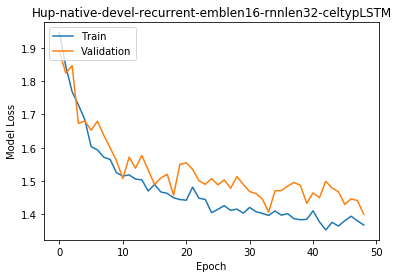

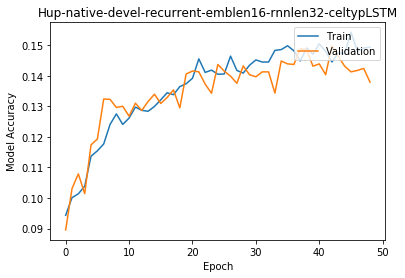

measures dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


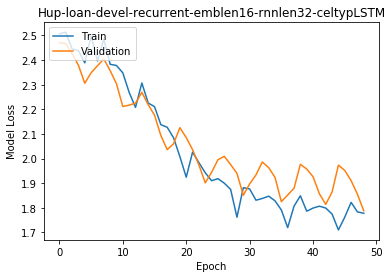

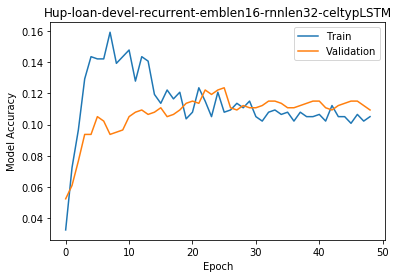

In [168]:
settings = config.AttentionSettings(rnn_cell_type='LSTM', embedding_len=32, 
                                    rnn_output_len=32, recurrent_l2=0.0015,
                                    rnn_levels=2)

perform_prediction_by_language(languages='Hup', 
                               form='Tokens', 
                               detect_type='dual', 
                               model_type='recurrent', 
                               test_split=0.20,
                               settings=settings)

# Troubleshooting -- Get single language table

In [88]:
# Define get table
def get_language_table(language=None, form=None):
    try:
        with open('wold.bin', 'rb') as f:
            lex = pickle.load(f)
    except:
        lex = LexibankDataset(
                'wold',
                transform={
                    "Loan": lambda x, y, z: 1 if x['Borrowed'].startswith('1') else 0}
                )
        with open('wold.bin', 'wb') as f:
            pickle.dump(lex, f)
            
    print(f'Language {language}.')
    table = lex.get_table(
                language=language,
                form=form,
                classification='Loan'
                )
    return table

table = get_language_table('Hup', 'FormChars')

Language Hup.
